In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

In [4]:
df_v1 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines = True)
df_v2 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json', lines = True)

In [5]:
df_v1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
df_v2.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [7]:
#As both the datasets look same, let's combine them into 1.
df = pd.concat([df_v1, df_v2], axis=0)

In [8]:
df.shape

(55328, 3)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [10]:
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [11]:
#Let's drop the links column as we don't need it.
df.drop('article_link', axis=1, inplace=True)

In [12]:
df.columns = ['text', 'labels']

In [13]:
df.duplicated().sum()

26825

In [14]:
df.drop_duplicates(keep='first', inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28503 entries, 0 to 28589
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    28503 non-null  object
 1   labels  28503 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 668.0+ KB


In [16]:
df['labels'].value_counts()

labels
0    14951
1    13552
Name: count, dtype: int64

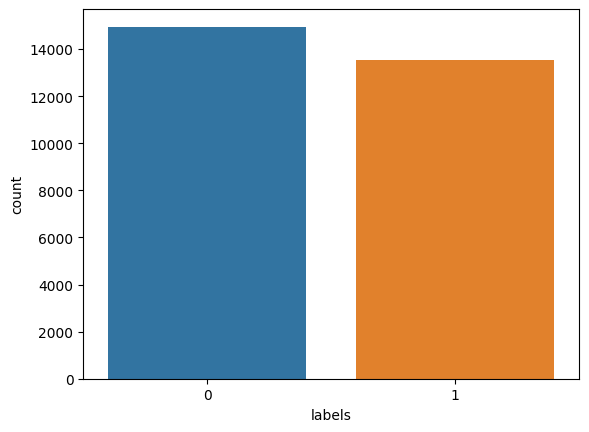

In [17]:
#Let's see some visuals
sns.countplot(x= df['labels'])
plt.show()

<Axes: xlabel='labels', ylabel='Count'>

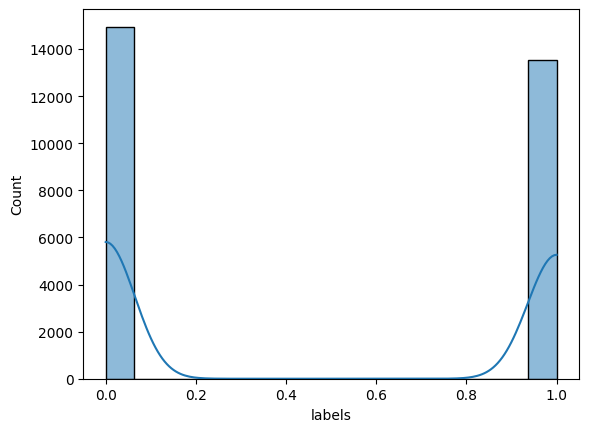

In [18]:
sns.histplot(df['labels'], kde=True)

In [19]:
#Cleaning Text
regex = re.compile('[^a-z\s]')

df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda x: regex.sub('', x))
df['text'] = df['text'].str.replace('rt|http', '', regex = True)
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [20]:
#Tokenizing and removing stop words
df['text'] = df['text'].apply(word_tokenize)

stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

In [21]:
#Stemming
stemmer = SnowballStemmer('english')
df['text'] = df['text'].apply(lambda x: [stemmer.stem(w) for w in x])
# Joining the words back into a single text
df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [23]:
all_words = ' '.join(word for word in df['text'])

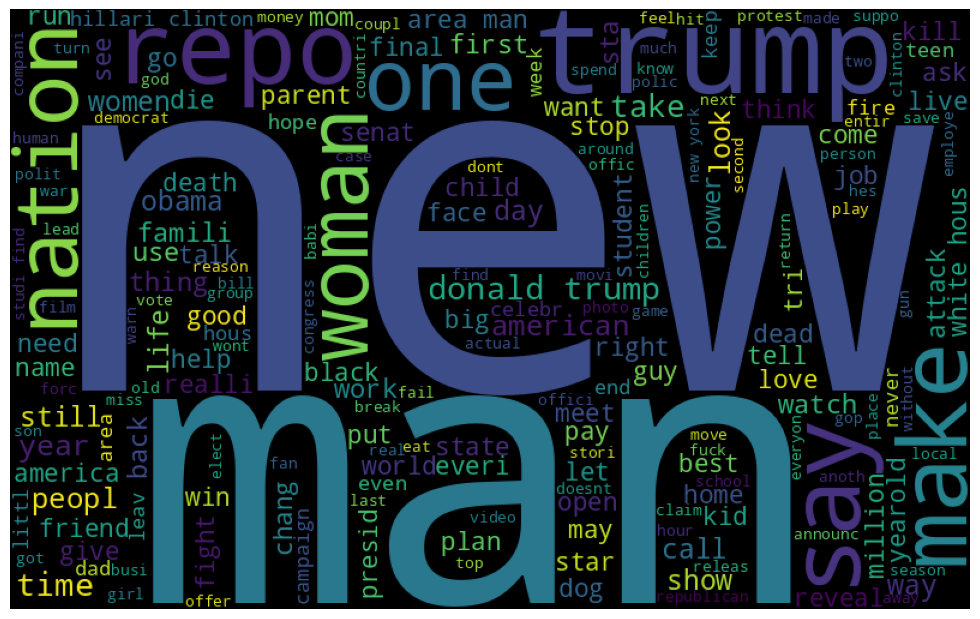

In [24]:
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', 
                min_font_size = 10).generate(all_words)

plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

In [25]:
X = np.array(df['text'])
y = np.array(df['labels'])

In [26]:
cv = CountVectorizer()
X = cv.fit_transform(X)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from textblob import TextBlob


In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['labels'], test_size=0.2, random_state=42)


In [30]:
# Use TfidfVectorizer to convert text data into numerical features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [31]:
# Initialize and train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [32]:
# Make predictions on the test data
y_pred = nb_classifier.predict(X_test_tfidf)


In [34]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.7698649359761446
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      2991
           1       0.76      0.75      0.76      2710

    accuracy                           0.77      5701
   macro avg       0.77      0.77      0.77      5701
weighted avg       0.77      0.77      0.77      5701



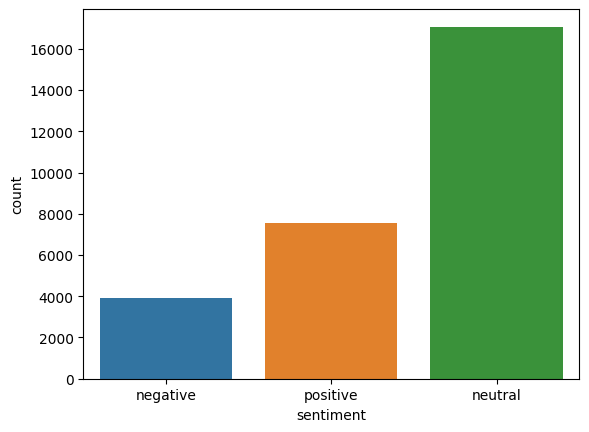

In [36]:
# Sentiment Analysis
def sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity < 0:
        return 'negative'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'positive'

# Apply sentiment analysis to your dataset
df['sentiment'] = df['text'].apply(sentiment)

# Count and visualize the sentiment distribution
sns.countplot(x='sentiment', data=df)
plt.show()


In [37]:
# Detect Sarcasm
def detect_sarcasm(text):
    tfidf_vectorized_text = tfidf_vectorizer.transform([text])
    prediction = nb_classifier.predict(tfidf_vectorized_text)
    return 'Sarcastic' if prediction == 1 else 'Not Sarcastic'

# Add a new column indicating whether each headline is classified as sarcastic or not
df['sarcasm_detected'] = df['text'].apply(detect_sarcasm)

# Display the sarcasm detection results
print(df[['text', 'sarcasm_detected']])


                                                    text sarcasm_detected
0      former versac store clerk sue secret black cod...    Not Sarcastic
1      roseann reviv catch thorni polit mood better wors    Not Sarcastic
2      mom sta fear son web seri closest thing grandc...        Sarcastic
3      boehner want wife listen come altern debtreduc...        Sarcastic
4                 rowl wish snape happi bihday magic way    Not Sarcastic
...                                                  ...              ...
28497  tyson hold contest let fan submit new idea tou...        Sarcastic
28509  increas cocki berni sander announc wont take d...    Not Sarcastic
28520  cashstrap zuckerberg forc sell million faceboo...        Sarcastic
28544  groceri store bar actual great littl happi hou...        Sarcastic
28589  studi marathon spectat attend sick thrill watc...        Sarcastic

[28503 rows x 2 columns]


LSTM

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [42]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])
data = pad_sequences(sequences, maxlen=max_sequence_length)


In [43]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, df['labels'], test_size=0.2, random_state=42)


In [45]:
# Build an LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(len(word_index) + 1, 128, input_length=max_sequence_length))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
# Train the LSTM model
history= lstm_model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
713/713 [==============================] - 106s 149ms/step - loss: 0.0417 - accuracy: 0.9853
Epoch 2/5
713/713 [==============================] - 112s 157ms/step - loss: 0.0232 - accuracy: 0.9918
Epoch 3/5
713/713 [==============================] - 110s 154ms/step - loss: 0.0154 - accuracy: 0.9947
Epoch 4/5
713/713 [==============================] - 110s 155ms/step - loss: 0.0128 - accuracy: 0.9961
Epoch 5/5
713/713 [==============================] - 106s 148ms/step - loss: 0.0135 - accuracy: 0.9963


In [58]:
# Evaluate the LSTM model
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Model - Loss: {loss}, Accuracy: {accuracy}")

179/179 [==============================] - 9s 49ms/step - loss: 1.3770 - accuracy: 0.7653
LSTM Model - Loss: 1.376960277557373, Accuracy: 0.7653043270111084


In [59]:
# Predict sarcasm on the test data
y_pred = lstm_model.predict(X_test)

# Convert the predictions to binary labels
y_pred_labels = [1 if pred > 0.5 else 0 for pred in y_pred]

# Print the sarcasm detection results
results = ["Sarcastic" if label == 1 else "Not Sarcastic" for label in y_pred_labels]
print(results)


179/179 [==============================] - 9s 51ms/step
['Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Sarcastic', 'Sarcastic', 'Sarcastic', 'Sarcastic', 'Sarcastic', 'Sarcastic', 'Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcast

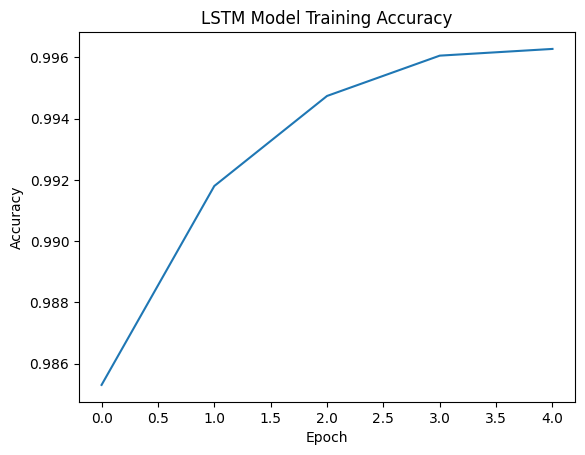

In [60]:
# Plot a graph of model training history
plt.plot(history.history['accuracy'])
plt.title('LSTM Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


**CNN**

In [62]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


In [63]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])
data = pad_sequences(sequences, maxlen=max_sequence_length)


In [67]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, df['labels'], test_size=0.2, random_state=42)


In [68]:
# Build a CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(len(word_index) + 1, 128, input_length=max_sequence_length))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [69]:
# Train the CNN model
history = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32)

# Evaluate the CNN model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Model - Loss: {loss}, Accuracy: {accuracy}")


Epoch 1/5
713/713 [==============================] - 32s 44ms/step - loss: 0.6464 - accuracy: 0.6131
Epoch 2/5
713/713 [==============================] - 31s 43ms/step - loss: 0.5689 - accuracy: 0.6767
Epoch 3/5
713/713 [==============================] - 30s 43ms/step - loss: 0.5085 - accuracy: 0.7025
Epoch 4/5
713/713 [==============================] - 32s 45ms/step - loss: 0.4809 - accuracy: 0.7127
Epoch 5/5
179/179 [==============================] - 2s 11ms/step - loss: 0.7875 - accuracy: 0.6304
CNN Model - Loss: 0.7875286936759949, Accuracy: 0.6304157376289368


In [70]:
# Predict sarcasm on the test data
y_pred = cnn_model.predict(X_test)

# Convert the predictions to binary labels
y_pred_labels = [1 if pred > 0.5 else 0 for pred in y_pred]

# Print the sarcasm detection results
results = ["Sarcastic" if label == 1 else "Not Sarcastic" for label in y_pred_labels]
print(results)


179/179 [==============================] - 2s 10ms/step
['Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Not Sarcastic', 'Sarcastic', 'Not Sarcastic', 'Not Sarcastic

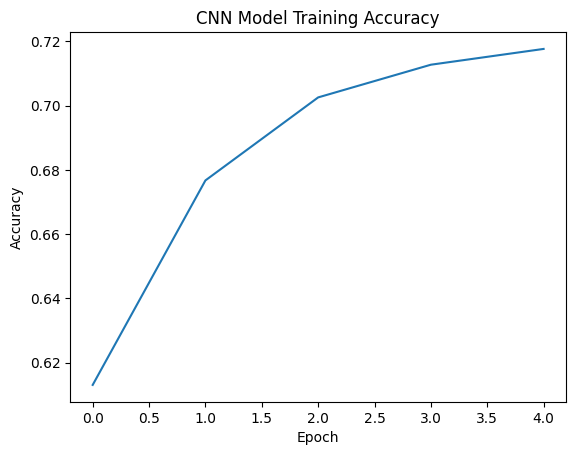

In [74]:
# Plot a graph of model training history
plt.plot(history.history['accuracy'])
plt.title('CNN Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

**Attention Based**

Epoch 1/5
891/891 [==============================] - 65s 68ms/step - loss: 0.4876 - accuracy: 0.7577
Epoch 2/5
891/891 [==============================] - 60s 67ms/step - loss: 0.3462 - accuracy: 0.8484
Epoch 3/5
891/891 [==============================] - 57s 64ms/step - loss: 0.2741 - accuracy: 0.8832
Epoch 4/5
891/891 [==============================] - 58s 66ms/step - loss: 0.2106 - accuracy: 0.9100
Epoch 5/5
891/891 [==============================] - 56s 63ms/step - loss: 0.1543 - accuracy: 0.9349


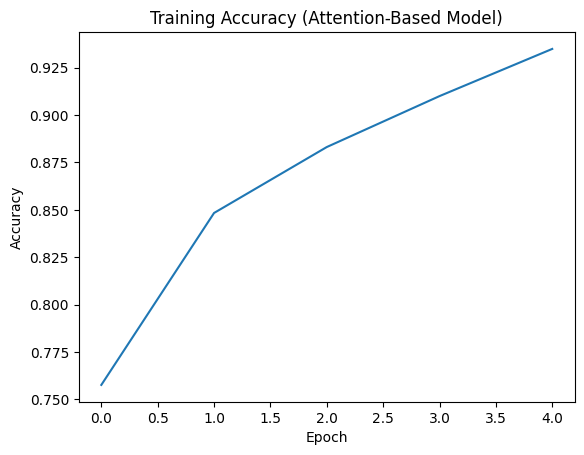

In [87]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate
from keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Layer

# Define AttentionLayer as shown in the previous response
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        q, k, v = inputs
        attn_score = tf.matmul(q, k, transpose_b=True)
        attn_score = tf.nn.softmax(attn_score)
        output = tf.matmul(attn_score, v)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[3]

# Tokenize and pad sequences
max_words = 10000
max_sequence_length = 20

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])
X_sequences = tokenizer.texts_to_sequences(df['text'])
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Define the input layer with the correct input shape
input_layer = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_layer = Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length)(input_layer)

# Bi-LSTM layer
bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)

# Attention mechanism
attention = AttentionLayer()([bi_lstm, bi_lstm, bi_lstm])

# Concatenate Bi-LSTM and attention output
combined = Concatenate(axis=-1)([bi_lstm, attention])

# Fully connected layer for binary classification
output = Dense(1, activation='sigmoid')(combined)

# Create the attention-based model
attention_model = Model(inputs=input_layer, outputs=output)

attention_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Reshape labels for binary classification
y = df['labels'].values  # Convert labels to a NumPy array
y = y.reshape(-1, 1)  # Reshape to match model output shape

# Train the attention-based model
history = attention_model.fit(X_padded, y, epochs=5, batch_size=32)

# Plot training accuracy for the model
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy (Attention-Based Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
# Iterate through the dataset and print sarcasm detection for each headline
for headline in df['text']:
    # Tokenize and pad the headline
    headline_sequence = tokenizer.texts_to_sequences([headline])
    padded_headline = pad_sequences(headline_sequence, maxlen=max_sequence_length, padding='post', truncating='post')
    
    # Make a prediction using the trained model
    prediction = attention_model.predict(padded_headline)
    
    # Threshold for classifying as sarcasm (adjust as needed)
    sarcasm_threshold = 0.5
    
    # Print the result
    if prediction[0][0] >= sarcasm_threshold:
        print(f"Sarcasm Detected: {headline}")
    else:
        print(f"Not Sarcasm: {headline}")


1/1 [==============================] - 1s 846ms/step
Not Sarcasm: former versac store clerk sue secret black code minor shopper
1/1 [==============================] - 0s 24ms/step
Not Sarcasm: roseann reviv catch thorni polit mood better wors
1/1 [==============================] - 0s 28ms/step
Sarcasm Detected: mom sta fear son web seri closest thing grandchild
1/1 [==============================] - 0s 24ms/step
Sarcasm Detected: boehner want wife listen come altern debtreduct idea
1/1 [==============================] - 0s 24ms/step
Not Sarcasm: rowl wish snape happi bihday magic way
1/1 [==============================] - 0s 27ms/step
Not Sarcasm: advanc world women
1/1 [==============================] - 0s 24ms/step
Not Sarcasm: fascin case eat labgrown meat
1/1 [==============================] - 0s 25ms/step
Not Sarcasm: ceo send kid school work compani
1/1 [==============================] - 0s 28ms/step
Not Sarcasm: top snake handler leav sink huckabe campaign
1/1 [=================

**RoBERTa**